In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
import pandas as pd
import ast
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from PIL import Image
import warnings

# Suppress the specific FutureWarning about downcasting
warnings.filterwarnings('ignore', category=FutureWarning, message='Downcasting object dtype arrays on .fillna')

# Define disease labels for CheXpert
disease_labels = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]

In [4]:
class CheXpertDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform or transforms.ToTensor()
        self.disease_labels = disease_labels
        self.base_dir = '/shared/home/nas6781/'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['Path']
        full_path = os.path.join(self.base_dir, image_path)
    
        try:
            image = Image.open(full_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {full_path}: {e}")
            return torch.zeros(3, 224, 224), torch.zeros(len(self.disease_labels))
    
        if self.transform:
            image = self.transform(image)
    
        labels = row[disease_labels].fillna(0).replace(-1, 0)
        labels = labels.infer_objects(copy=False).astype(float)
        return image, torch.FloatTensor(labels.values)

class PadChestDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['ImageID'])

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return torch.zeros(3, 224, 224), torch.zeros(1)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row['no_findings'], dtype=torch.float32).unsqueeze(0)
        return image, label

In [6]:
def get_balanced_binary_datasets_fast(dataset):
    """Creates balanced binary classification datasets using vectorized operations"""
    print("\nCreating balanced binary datasets...")
    
    # Get all labels at once using vectorized operations
    print("Collecting labels...")
    all_labels = []
    batch_size = 1000  # Process in batches to avoid memory issues
    
    for i in tqdm(range(0, len(dataset), batch_size), desc="Loading labels"):
        batch_end = min(i + batch_size, len(dataset))
        batch_labels = torch.stack([dataset[j][1] for j in range(i, batch_end)])
        all_labels.append(batch_labels)
    
    all_labels = torch.cat(all_labels)
    print("Computing positive/negative masks...")
    pos_mask = (all_labels.sum(dim=1) > 0)
    
    # Use numpy for faster index operations
    pos_indices = torch.where(pos_mask)[0].numpy()
    neg_indices = torch.where(~pos_mask)[0].numpy()
    
    print(f"Found {len(pos_indices)} positive samples and {len(neg_indices)} negative samples")
    
    # Randomly sample without replacement for better balance
    min_count = min(len(pos_indices), len(neg_indices))
    pos_indices = np.random.choice(pos_indices, min_count, replace=False)
    neg_indices = np.random.choice(neg_indices, min_count, replace=False)
    
    print(f"Using {min_count*2} balanced samples ({min_count} per class)")
    
    # Combine and shuffle indices
    balanced_indices = np.concatenate([pos_indices, neg_indices])
    np.random.shuffle(balanced_indices)
    
    # Calculate split sizes
    total = len(balanced_indices)
    train_size = int(0.7 * total)
    val_size = int(0.15 * total)
    
    # Split indices
    train_indices = balanced_indices[:train_size]
    val_indices = balanced_indices[train_size:train_size+val_size]
    test_indices = balanced_indices[train_size+val_size:]
    
    print(f"Split sizes - Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")
    
    return (Subset(dataset, train_indices),
            Subset(dataset, val_indices),
            Subset(dataset, test_indices))

def binary_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    binary_labels = torch.stack([(label.sum() > 0).float().unsqueeze(0) for label in labels])
    return images, binary_labels

def load_padchest_data():
    """Load and preprocess PadChest dataset"""
    print("Loading PadChest data...")
    df = pd.read_csv('/shared/home/nas6781/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv')
    df = df.dropna(subset=['Labels', 'ImageID'])
    df['ImageID'] = df['ImageID'].astype(str)
    df['ImageID'] = df['ImageID'].str.replace('.dicom', '.png')
    df['ImageID'] = df['ImageID'].str.replace('.dcm', '.png')
    
    def safe_eval(val):
        try:
            return ast.literal_eval(str(val))
        except:
            return []
    
    df['Labels'] = df['Labels'].apply(safe_eval)
    
    # Create binary label for no findings
    df['no_findings'] = df['Labels'].apply(
        lambda x: 1 if len(x) == 1 and isinstance(x[0], str) and x[0].strip().lower() == 'normal' else 0
    )
    
    # Filter for existing images
    image_dir = '/shared/home/nas6781/Padchest'
    existing_images = set(os.listdir(image_dir))
    df = df[df['ImageID'].isin(existing_images)]
    
    print(f"Loaded {len(df)} PadChest images")
    return df

In [7]:
def get_transforms():
    """Get train and validation transforms with augmentation"""
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=30, patience=5):
    """Train model with early stopping"""
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate accuracy
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            
            train_pbar.set_postfix({'loss': running_loss/train_total, 'acc': train_correct/train_total})

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                
                # Calculate accuracy
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                
                val_pbar.set_postfix({'loss': val_loss/val_total, 'acc': val_correct/val_total})

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        print(f"\nEpoch {epoch+1}:")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_correct/train_total:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_correct/val_total:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
            }, 'best_combined_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

In [8]:
def evaluate_dataset(model, dataset, device, dataset_name):
    """Evaluate model on a specific dataset"""
    model.eval()
    all_labels = []
    all_preds = []
    all_scores = []
    
    print(f"\nEvaluating model on {dataset_name}...")
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=False,
        num_workers=4,
        collate_fn=binary_collate_fn
    )
    
    with torch.no_grad():
        test_pbar = tqdm(dataloader, desc=f'Testing {dataset_name}')
        for images, labels in test_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())
    
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()
    
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }
    
    return metrics, all_labels, all_preds, all_scores

In [9]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load datasets
print("Loading datasets...")
df_padchest = load_padchest_data()

# Get transforms
train_transform, val_transform = get_transforms()

# Create datasets
padchest_dataset = PadChestDataset(
    dataframe=df_padchest,
    image_dir='/shared/home/nas6781/Padchest',
    transform=train_transform
)

chexpert_dataset = CheXpertDataset(
    csv_file='/shared/home/nas6781/CheXpert-v1.0-small/train.csv',
    transform=train_transform
)

# Get balanced splits
print("Creating balanced splits...")
padchest_train, padchest_val, padchest_test = get_balanced_binary_datasets_fast(padchest_dataset)
chexpert_train, chexpert_val, chexpert_test = get_balanced_binary_datasets_fast(chexpert_dataset)



Using device: cuda
Loading datasets...
Loading PadChest data...
Loaded 28540 PadChest images
Creating balanced splits...

Creating balanced binary datasets...


Loading labels: 100%|██████████| 29/29 [1:05:31<00:00, 135.56s/it]


Computing positive/negative masks...
Found 9207 positive samples and 19333 negative samples
Using 18414 balanced samples (9207 per class)
Split sizes - Train: 12889, Val: 2762, Test: 2763

Creating balanced binary datasets...


Loading labels: 100%|██████████| 224/224 [57:51<00:00, 15.50s/it]

Computing positive/negative masks...
Found 212273 positive samples and 11141 negative samples
Using 22282 balanced samples (11141 per class)
Split sizes - Train: 15597, Val: 3342, Test: 3343


In [10]:
# Combine datasets
train_dataset = ConcatDataset([padchest_train, chexpert_train])
val_dataset = ConcatDataset([padchest_val, chexpert_val])
test_dataset = ConcatDataset([padchest_test, chexpert_test])

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    collate_fn=binary_collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=binary_collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=binary_collate_fn
)

# Initialize DenseNet-121 model
print("Initializing DenseNet-121 model...")
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 1)
model = model.to(device)

# Training setup
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Train model
print("Starting training...")
model, train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=30,
    patience=5
)

# Plot training curves
plot_training_curves(train_losses, val_losses, 'training_curves.png')

print("Training completed!")



/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initializing DenseNet-121 model...


/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Starting training...


Epoch 1/30 [Val]: 100%|██████████| 191/191 [01:44<00:00,  1.84it/s, loss=0.0191, acc=0.651]



Epoch 1:
Train Loss: 0.6327, Train Acc: 0.6340
Val Loss: 0.6120, Val Acc: 0.6507


Epoch 2/30 [Val]: 100%|██████████| 191/191 [01:38<00:00,  1.95it/s, loss=0.019, acc=0.668] 



Epoch 2:
Train Loss: 0.6133, Train Acc: 0.6555
Val Loss: 0.6071, Val Acc: 0.6683


Epoch 3/30 [Val]: 100%|██████████| 191/191 [01:36<00:00,  1.97it/s, loss=0.0187, acc=0.673]



Epoch 3:
Train Loss: 0.5998, Train Acc: 0.6647
Val Loss: 0.5978, Val Acc: 0.6727


Epoch 4/30 [Val]: 100%|██████████| 191/191 [01:37<00:00,  1.96it/s, loss=0.0187, acc=0.673]



Epoch 4:
Train Loss: 0.5943, Train Acc: 0.6735
Val Loss: 0.5965, Val Acc: 0.6727


Epoch 5/30 [Val]: 100%|██████████| 191/191 [01:37<00:00,  1.96it/s, loss=0.0185, acc=0.678]



Epoch 5:
Train Loss: 0.5864, Train Acc: 0.6808
Val Loss: 0.5909, Val Acc: 0.6784


Epoch 6/30 [Val]: 100%|██████████| 191/191 [01:36<00:00,  1.98it/s, loss=0.0185, acc=0.676]



Epoch 6:
Train Loss: 0.5809, Train Acc: 0.6820
Val Loss: 0.5913, Val Acc: 0.6758


Epoch 7/30 [Val]: 100%|██████████| 191/191 [01:36<00:00,  1.97it/s, loss=0.0188, acc=0.665]



Epoch 7:
Train Loss: 0.5743, Train Acc: 0.6880
Val Loss: 0.5995, Val Acc: 0.6651


Epoch 8/30 [Val]: 100%|██████████| 191/191 [01:38<00:00,  1.94it/s, loss=0.0186, acc=0.681]



Epoch 8:
Train Loss: 0.5694, Train Acc: 0.6948
Val Loss: 0.5943, Val Acc: 0.6814


Epoch 9/30 [Val]: 100%|██████████| 191/191 [01:36<00:00,  1.97it/s, loss=0.0187, acc=0.686]



Epoch 9:
Train Loss: 0.5505, Train Acc: 0.7049
Val Loss: 0.5969, Val Acc: 0.6864


Epoch 10/30 [Val]: 100%|██████████| 191/191 [01:36<00:00,  1.98it/s, loss=0.0187, acc=0.686]



Epoch 10:
Train Loss: 0.5395, Train Acc: 0.7128
Val Loss: 0.5971, Val Acc: 0.6864
Early stopping triggered
Training completed!


In [11]:
# Load best model for testing
print("\nLoading best model for testing...")
checkpoint = torch.load('best_combined_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Evaluate on CheXpert test set
chexpert_metrics, chexpert_labels, chexpert_preds, chexpert_scores = evaluate_dataset(
    model, chexpert_test, device, "CheXpert"
)
plot_dataset_results(chexpert_metrics, chexpert_labels, chexpert_preds, chexpert_scores, "CheXpert")

# Evaluate on PadChest test set
padchest_metrics, padchest_labels, padchest_preds, padchest_scores = evaluate_dataset(
    model, padchest_test, device, "PadChest"
)
plot_dataset_results(padchest_metrics, padchest_labels, padchest_preds, padchest_scores, "PadChest")

# Save test metrics
results = {
    'CheXpert': chexpert_metrics,
    'PadChest': padchest_metrics
}
with open('test_metrics.json', 'w') as f:
    json.dump(results, f, indent=2)

# Print test results
print("\nTest Set Results:")
for dataset_name, metrics in results.items():
    print(f"\n{dataset_name} Results:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")


Loading best model for testing...

Evaluating model on CheXpert...


Testing CheXpert: 100%|██████████| 105/105 [00:07<00:00, 13.40it/s]



Evaluating model on PadChest...


Testing PadChest: 100%|██████████| 87/87 [01:38<00:00,  1.13s/it]



Test Set Results:

CheXpert Results:
Accuracy: 0.7478
Precision: 0.7685
Recall: 0.7210
F1: 0.7440
Auroc: 0.8090

PadChest Results:
Accuracy: 0.5986
Precision: 0.6210
Recall: 0.5159
F1: 0.5636
Auroc: 0.6421


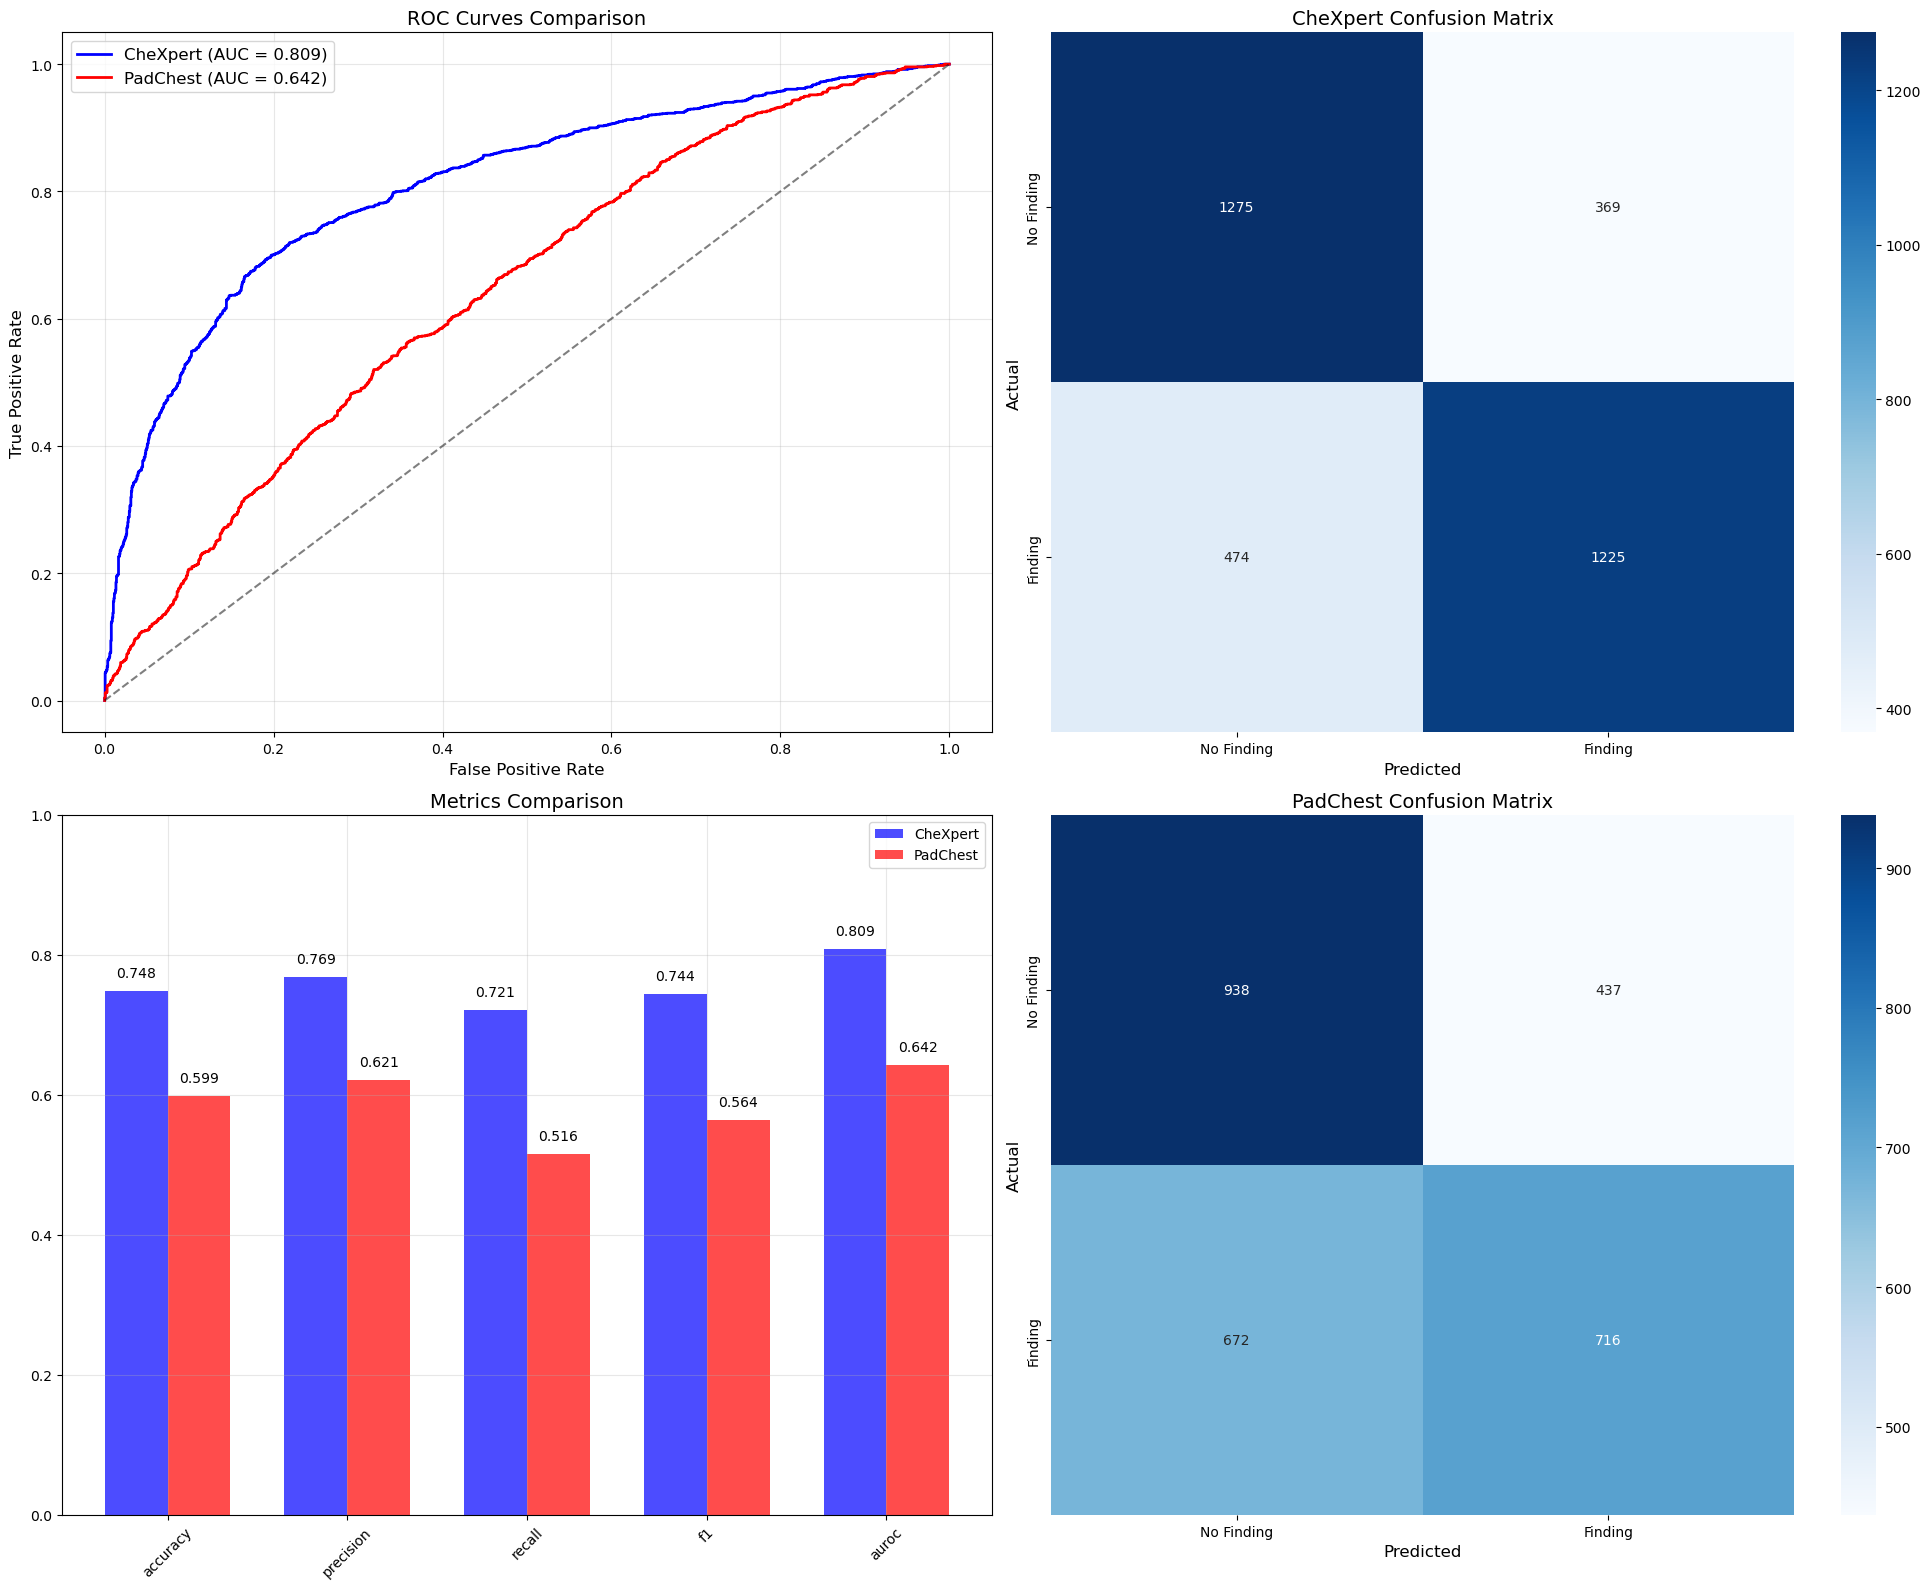


Detailed Metrics Comparison:

CheXpert Metrics:
Accuracy: 0.7478
Precision: 0.7685
Recall: 0.7210
F1: 0.7440
Auroc: 0.8090

PadChest Metrics:
Accuracy: 0.5986
Precision: 0.6210
Recall: 0.5159
F1: 0.5636
Auroc: 0.6421


In [14]:
def plot_explicit_results(chexpert_metrics, chexpert_labels, chexpert_preds, chexpert_scores,
                         padchest_metrics, padchest_labels, padchest_preds, padchest_scores):
    """Plot explicit ROC curves and confusion matrices for both datasets"""
    
    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot ROC curves together
    fpr_chexpert, tpr_chexpert, _ = roc_curve(chexpert_labels, chexpert_scores)
    fpr_padchest, tpr_padchest, _ = roc_curve(padchest_labels, padchest_scores)
    
    axes[0, 0].plot(fpr_chexpert, tpr_chexpert, 
                    label=f'CheXpert (AUC = {chexpert_metrics["auroc"]:.3f})',
                    color='blue', linewidth=2)
    axes[0, 0].plot(fpr_padchest, tpr_padchest, 
                    label=f'PadChest (AUC = {padchest_metrics["auroc"]:.3f})',
                    color='red', linewidth=2)
    axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 0].set_title('ROC Curves Comparison', fontsize=14)
    axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend(fontsize=12)
    
    # Plot Confusion Matrices
    # CheXpert Confusion Matrix
    cm_chexpert = confusion_matrix(chexpert_labels, chexpert_preds)
    sns.heatmap(cm_chexpert, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'],
                ax=axes[0, 1])
    axes[0, 1].set_title('CheXpert Confusion Matrix', fontsize=14)
    axes[0, 1].set_xlabel('Predicted', fontsize=12)
    axes[0, 1].set_ylabel('Actual', fontsize=12)
    
    # PadChest Confusion Matrix
    cm_padchest = confusion_matrix(padchest_labels, padchest_preds)
    sns.heatmap(cm_padchest, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'],
                ax=axes[1, 1])
    axes[1, 1].set_title('PadChest Confusion Matrix', fontsize=14)
    axes[1, 1].set_xlabel('Predicted', fontsize=12)
    axes[1, 1].set_ylabel('Actual', fontsize=12)
    
    # Plot metrics comparison
    metrics_df = pd.DataFrame({
        'CheXpert': chexpert_metrics,
        'PadChest': padchest_metrics
    }).T
    
    # Plot metrics as bar charts
    metrics_names = list(chexpert_metrics.keys())
    x = np.arange(len(metrics_names))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, list(chexpert_metrics.values()), width, label='CheXpert', color='blue', alpha=0.7)
    axes[1, 0].bar(x + width/2, list(padchest_metrics.values()), width, label='PadChest', color='red', alpha=0.7)
    
    axes[1, 0].set_title('Metrics Comparison', fontsize=14)
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(metrics_names, rotation=45)
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add value labels on top of bars
    for i, v in enumerate(chexpert_metrics.values()):
        axes[1, 0].text(i - width/2, v + 0.02, f'{v:.3f}', ha='center')
    for i, v in enumerate(padchest_metrics.values()):
        axes[1, 0].text(i + width/2, v + 0.02, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('explicit_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed metrics
    print("\nDetailed Metrics Comparison:")
    print("\nCheXpert Metrics:")
    for metric, value in chexpert_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    
    print("\nPadChest Metrics:")
    for metric, value in padchest_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

# Call the function after evaluation
plot_explicit_results(
    chexpert_metrics, chexpert_labels, chexpert_preds, chexpert_scores,
    padchest_metrics, padchest_labels, padchest_preds, padchest_scores
)